In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from typing import Literal
from collections.abc import Callable

%matplotlib inline

In [2]:
###moduleDir = 'MACHINE LEARNING'
outDir = os.path.join('output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed = RANDOM_STATE)

NOISE = 0.1
EPOCHS = 20001
N_SAMPLES = 1280
ALPHA = 0.1
NUM_HIDDEN = 8

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 150,
          'image.cmap': 'jet',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }
CMAP = 'coolwarm'
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE=0.2

<Figure size 1500x600 with 0 Axes>

In [3]:
def fn_plot_decision_boundary(pred_func:Callable[[], np.float64],
                             X_tr : np.ndarray,   # training features
                             X_ts : np.ndarray,    # testing features
                             y_tr : np.ndarray,    # training labels
                             y_ts : np.ndarray    # testing labels
                             ):

    # set Min & Max values & give it some padding
    x_min, x_max = X_tr[:,0].min() - .05, X_tr[:,0].max() + .05
    y_min, y_max = X_tr[:,1].min() - .05, X_tr[:,1].max() + .05
    
    # grid size for mesh grid
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

    Z = pred_func(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    ax.contourf(xx, yy,Z, cmap = CMAP)  

    ax.scatter(X_tr[:,0], X_tr[:,1], c=y_tr.argmax(axis = 1),
              s=30, edgecolor='white', cmap='Spectral')  

    ax.scatter(X_ts[:,0], X_ts[:,1], c=y_ts.argmax(axis = 1),
              s=100, marker='*', edgecolor='pink', cmap='Spectral')  
    

In [4]:
X, y = datasets.make_circles((N_SAMPLES,N_SAMPLES),
                           shuffle = True, 
                           noise = NOISE,
                            random_state=RANDOM_STATE,factor = 0.7)
X[:5],y[:5]

(array([[-0.98577653,  0.01159097],
        [-0.33111765,  0.55858338],
        [-0.63020442, -0.7806988 ],
        [-0.09699527,  0.64821339],
        [ 0.84920898, -0.42633838]]),
 array([0, 1, 0, 1, 0], dtype=int64))

## Different way of plotting

In [5]:
data_df = pd.DataFrame(X, columns=['A','B'])

data_df['target'] = y

data_df.head()

,A,B,target
0,-0.985777,0.011591,0
1,-0.331118,0.558583,1
2,-0.630204,-0.780699,0
3,-0.096995,0.648213,1
4,0.849209,-0.426338,0


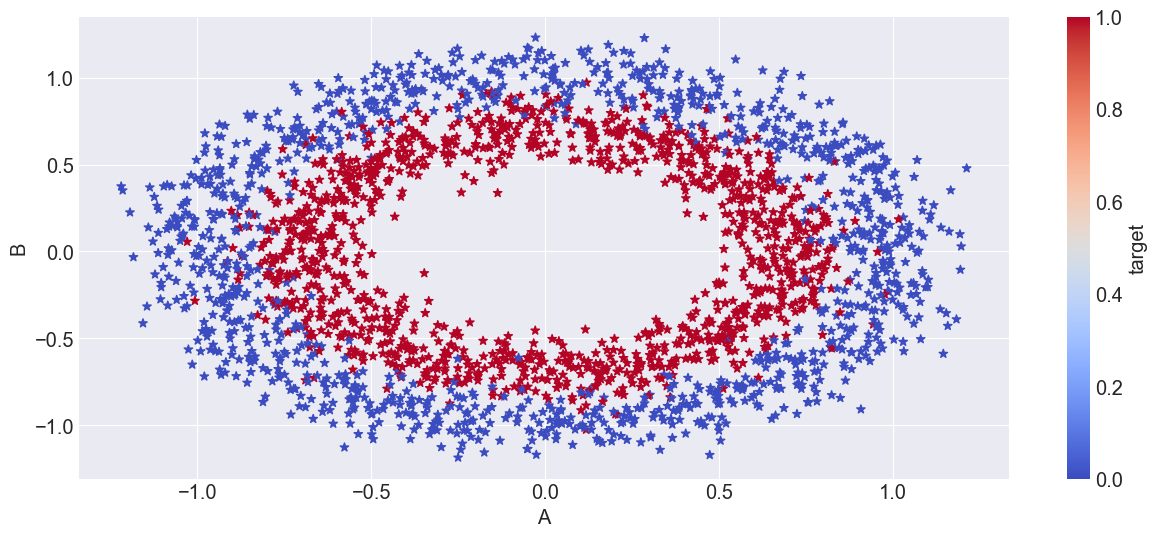

In [6]:
data_df.plot.scatter('A','B',
                    s = 40,
                    marker = '*',
                    c = 'target',
                    cmap = CMAP);

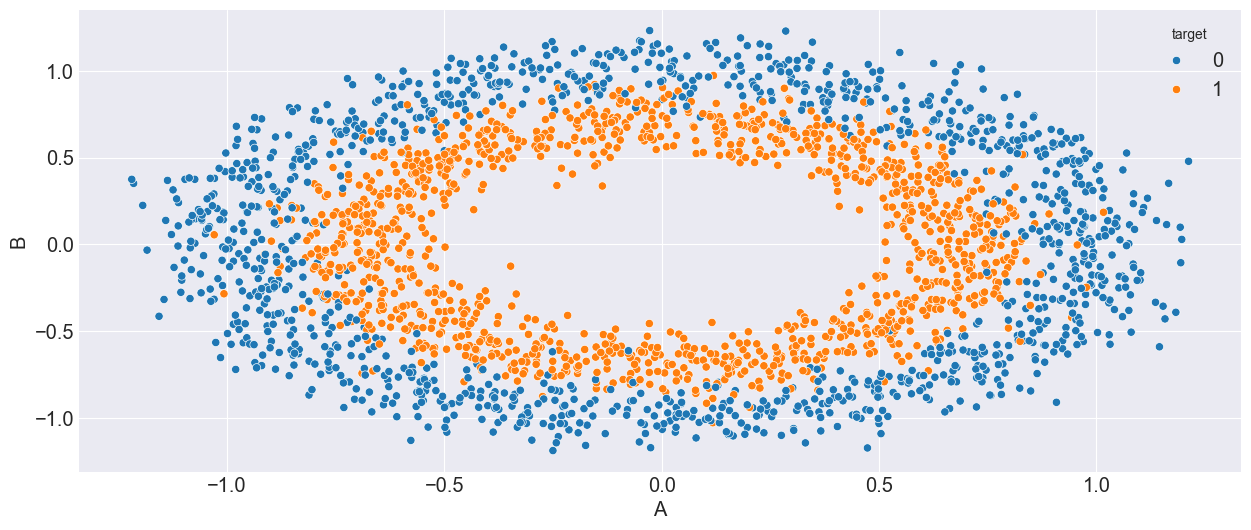

In [7]:
ax = sns.scatterplot(x = 'A',y='B',data = data_df,hue = 'target');

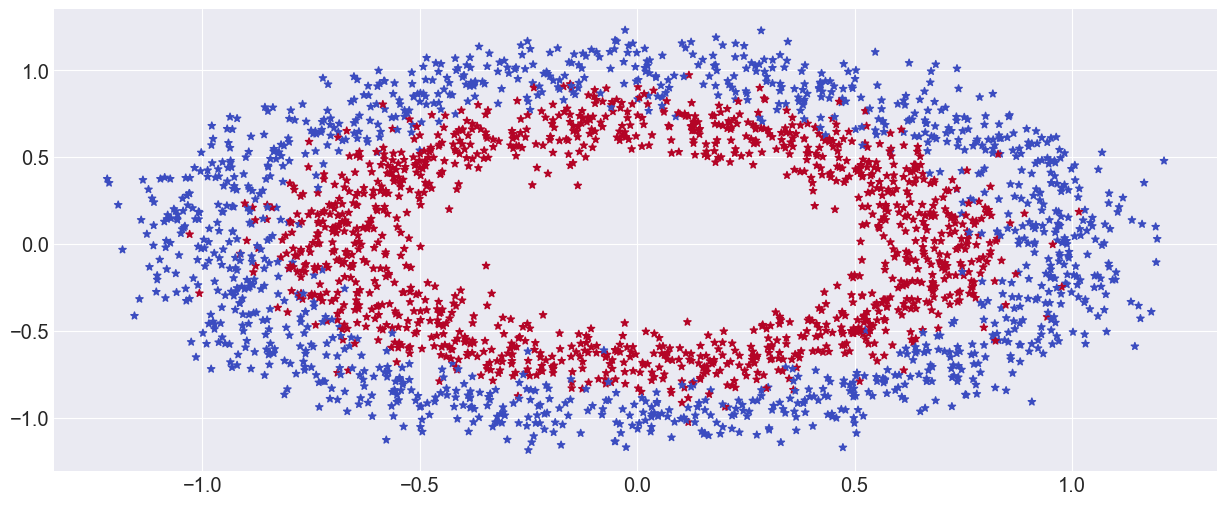

In [8]:
plt.scatter(X[:,0],X[:,1],s = 30,c= y,marker = '*',cmap=CMAP);

In [9]:
y.shape

(2560,)

In [10]:
y = pd.get_dummies(y).to_numpy()
y

array([[ True, False],
       [False,  True],
       [ True, False],
       ...,
       [False,  True],
       [ True, False],
       [ True, False]])

In [11]:
y.shape

(2560, 2)

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size = TEST_SIZE,
                                                stratify = y,
                                                random_state = RANDOM_STATE)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2048, 2), (512, 2), (2048, 2), (512, 2))

In [13]:
# if you really want to save on space, convert to float32
X_train = X_train.astype(np.float32)

X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)

y_test = y_test.astype(np.float32)


In [14]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [15]:
def fn_softmax(z:np.ndarray) -> np.ndarray:
    '''
    Args:
        z = a matrix of z values of shape (m, n_output)
    return:
        a matrix containing sigmoid values of z
    '''
    exp_sc = np.exp(z)
    return exp_sc / np.sum(exp_sc , axis = 1, keepdims = True)

In [16]:
sm = fn_softmax(np.asarray([[8,5,0],[-10,0.,10]]))
print(sm, '\n\nTotal of all values', sm.sum(axis=1))

[[9.52269826e-01 4.74107229e-02 3.19450938e-04]
 [2.06106005e-09 4.53978686e-05 9.99954600e-01]] 

Total of all values [1. 1.]


In [17]:
def fn_tanh(z: np.ndarray) -> np.ndarray: #z:array,aggregated values
    
     return np.tanh(z)  # returns Activation for each z
    
def fn_tanh_prime(a:np.ndarray) -> np.ndarray:  #a:array,aggregated values

    return 1.0 - np.tanh(a)**2   # derivative for each a

In [18]:
fn_tanh(np.asarray([[-1, 0.,1.],[-np.inf,0.,np.inf]]))


array([[-0.76159416,  0.        ,  0.76159416],
       [-1.        ,  0.        ,  1.        ]])

In [19]:
np.tanh(0.5)

0.46211715726000974

In [20]:
(1 - np.power(np.tanh(0.5),2))

0.7864477329659274

In [21]:
fn_tanh_prime(0.5)

0.7864477329659274

In [22]:
(1 - np.power(fn_tanh_prime(0.5),2))

0.3814999633127534

In [23]:
def calculate_loss (model : dict , X:np.ndarray,y:np.ndarray) -> np.float64:      # model : dict object , X: feature matrix,y : labels array

    W1,b1,W2,b2 = model['W1'],model['b1'],model['W2'],model['b2']
    
    m = X.shape[0]
    
    z1 = X.dot(W1) + b1    #aggregation
    a1 = fn_tanh(z1)       # Activation

    # layer2
    z2 = a1.dot(W2) + b2
    # activation of softmax
    a2 = fn_softmax(z2)

    data_loss = -(y* np.log(a2) + (1-y)* np.log(1-a2)).sum()
    
    return 1./m * data_loss


In [24]:
def predict (model : dict , X:np.ndarray) -> Literal:

    W1,b1,W2,b2 = model['W1'],model['b1'],model['W2'],model['b2']
    # Forward propogation
    z1 = X.dot(W1) + b1    #aggregation
    a1 = fn_tanh(z1)       # Activation

    # layer2
    z2 = a1.dot(W2) + b2
    #############################
    ####Changes for multiclass
    #############################
    # Softmax Activation 
    a2 = fn_softmax(z2)

    return np.argmax(a2, axis =1) # pick with one with highest probabilities

    

In [25]:
def build_model(nn_hdim : np.int64,  # number of nodes in hidden layer
               X : np.ndarray,       # training feature
               y : np.ndarray,       # training targets
               epochs : np.int64 = EPOCHS, # no of passes through training data for gradient descent
                alpha : np.float64 = ALPHA) -> dict:  # learning rate
    # returns ->  model : Dictionary object containing weights and biases

    W1 = np.random.rand(nn_input_dim,nn_hdim) / np.sqrt(nn_input_dim)
    W2 = np.random.rand(nn_hdim,nn_output_dim) / np.sqrt(nn_hdim)

    b1 = np.zeros((1,nn_hdim))
    b2 = np.zeros((1,nn_output_dim))

    curr_loss = 0

    loss = []
    epoch = []

    for i in range(0,epochs): # loop for number of epochs
        #############################
        ### Forward Propogation #####
        ############################
        #layer 1
        z1 = X.dot(W1) + b1    #aggregation
        a1 = fn_tanh(z1)       # Activation

        # layer2
        z2 = a1.dot(W2) + b2
        a2 = fn_softmax(z2)
        ########################
        ### Back Propogation ###
        ########################
        # Layer 2
        dz2= a2-y

        dW2 = (a1.T).dot(dz2)
        assert (W2.shape == dW2.shape), 'shape of W2 {} and shape of dW2 {}'.format(W2.shape, dW2.shape)

        db2 = np.sum(dz2, axis = 0, keepdims =True)
        assert (b2.shape == db2.shape), 'shape of b2 {} and shape of db2 {}'.format(b2.shape, db2.shape)

        da1 = dz2.dot(W2.T)
        assert (a1.shape == da1.shape), 'shape of a1 {} and shape of da1 {}'.format(a1.shape, da1.shape)

        dz1 = da1 * fn_tanh_prime(z1)
        assert (z1.shape == dz1.shape), 'shape of z1 {} and shape of dz1 {}'.format(z1.shape, dz1.shape)

        dW1 = (X.T).dot(dz1)
        assert (W1.shape == dW1.shape), 'shape of W1 {} and shape of dW1 {}'.format(W1.shape, dW1.shape)

        db1 = np.sum(dz1, axis = 0, keepdims =True)
        assert (b1.shape == db1.shape), 'shape of b1 {} and shape of db1 {}'.format(b1.shape, db1.shape)


        ############################
        ##### Gradient updates  ####
        ############################
        W1 += -alpha *dW1 / num_examples
        W2 += -alpha *dW2 / num_examples
        b1 += -alpha *db1 / num_examples
        b2 += -alpha *db2 / num_examples
    
        model = {'W1': W1,'b1':b1,'W2':W2,'b2':b2}  # store model in dict object.

        if i%100 == 0:            # for every nth epoch calculate loss for future plotting
            curr_loss = calculate_loss(model,X,y)
            loss.append(curr_loss)
            epoch.append(i)
            
        if i%1000 == 0:          # print loss every nth epoch
            print('loss after {} epochs : {}'.format(i,curr_loss))
            
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss

    return model    

In [26]:
num_examples, nn_input_dim = X_train.shape #training set size(rows and cols)
nn_output_dim = y_train.shape[1]  # output layer dimensionality

loss_hist = {}   # lists to facilitate plotting

In [27]:
# Build a model
model = build_model(NUM_HIDDEN, X_train, y_train,
                   epochs = EPOCHS,
                   alpha=ALPHA)

loss after 0 epochs : 1.3919320442455758
loss after 1000 epochs : 1.1721305189852251
loss after 2000 epochs : 0.6858348786747644
loss after 3000 epochs : 0.5104498589207977
loss after 4000 epochs : 0.43047824919592226
loss after 5000 epochs : 0.40411805147768104
loss after 6000 epochs : 0.3927917691984786
loss after 7000 epochs : 0.3865639436573068
loss after 8000 epochs : 0.3825396938071456
loss after 9000 epochs : 0.37964978519627
loss after 10000 epochs : 0.3774184963291435
loss after 11000 epochs : 0.3756072052431597
loss after 12000 epochs : 0.3740861908149232
loss after 13000 epochs : 0.3727808881029194
loss after 14000 epochs : 0.37164648458156535
loss after 15000 epochs : 0.3706545348785047
loss after 16000 epochs : 0.3697854179160452
loss after 17000 epochs : 0.3690241034507358
loss after 18000 epochs : 0.36835794898300134
loss after 19000 epochs : 0.36777570259268466
loss after 20000 epochs : 0.3672671410580344


### Prediction

In [28]:
model

{'W1': array([[ 1.93149266,  1.10310751,  1.77334403, -0.0049706 , -0.48096906,
         -0.41282131,  1.41562713, -0.00288862],
        [-0.49621729,  1.13604189, -0.26619501,  0.05715005,  1.64865102,
          1.80107515,  1.56397001,  0.05417153]]),
 'b1': array([[ 1.8423802 ,  1.40456665, -1.66701827, -1.56514779,  1.57945539,
         -1.64297016, -1.86175543, -1.914992  ]]),
 'W2': array([[-2.63241187,  3.06853259],
        [-3.32799581,  3.83570112],
        [ 3.7864277 , -3.38026835],
        [-1.42593903,  1.889592  ],
        [-3.04869966,  3.70772131],
        [ 3.79786495, -3.23760609],
        [ 2.79047528, -2.49266634],
        [-2.15468804,  2.61192138]]),
 'b2': array([[ 5.92019859, -5.92019859]])}

In [29]:
y_pred  = predict(model,X_train)
print('Accuracy score on Train Data:', accuracy_score(np.argmax(y_train,axis = 1), y_pred))


Accuracy score on Train Data: 0.92919921875


In [30]:
print(classification_report(np.argmax(y_train,axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1024
           1       0.93      0.93      0.93      1024

    accuracy                           0.93      2048
   macro avg       0.93      0.93      0.93      2048
weighted avg       0.93      0.93      0.93      2048



In [31]:
y_pred  = predict(model,X_test)
print('Accuracy score on Test Data:', accuracy_score(np.argmax(y_test,axis = 1), y_pred))


Accuracy score on Test Data: 0.935546875


In [32]:
print(classification_report(np.argmax(y_test,axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       256
           1       0.96      0.91      0.93       256

    accuracy                           0.94       512
   macro avg       0.94      0.94      0.94       512
weighted avg       0.94      0.94      0.94       512



Text(0.5, 1.0, 'Decision boundary')

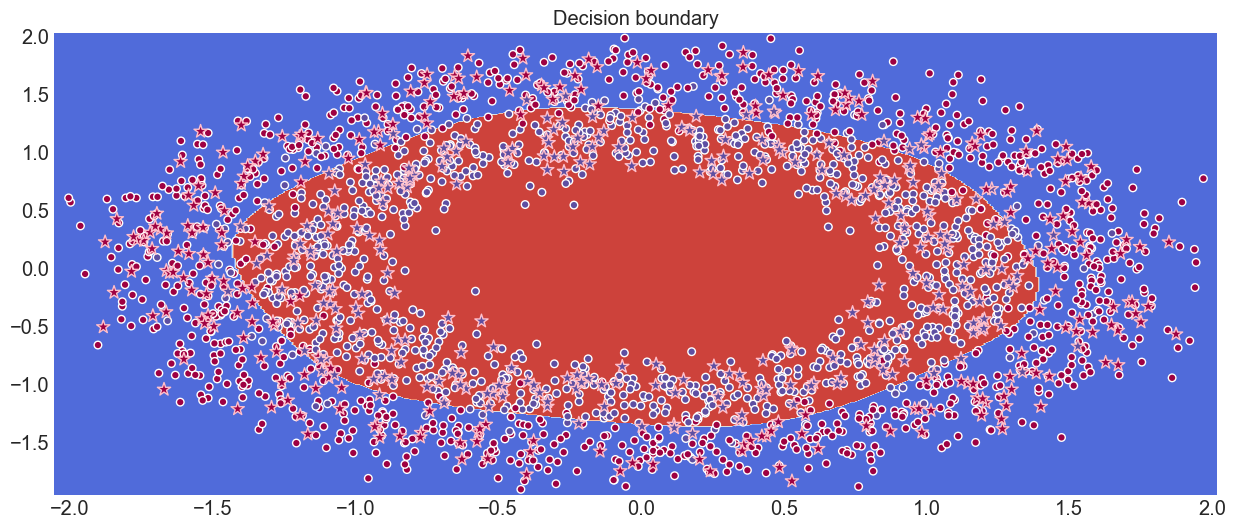

In [33]:
loss_df = pd.DataFrame(loss_hist)

fn_plot_decision_boundary(lambda x: predict(model, x), X_train,X_test, y_train,y_test)

plt.title("Decision boundary")

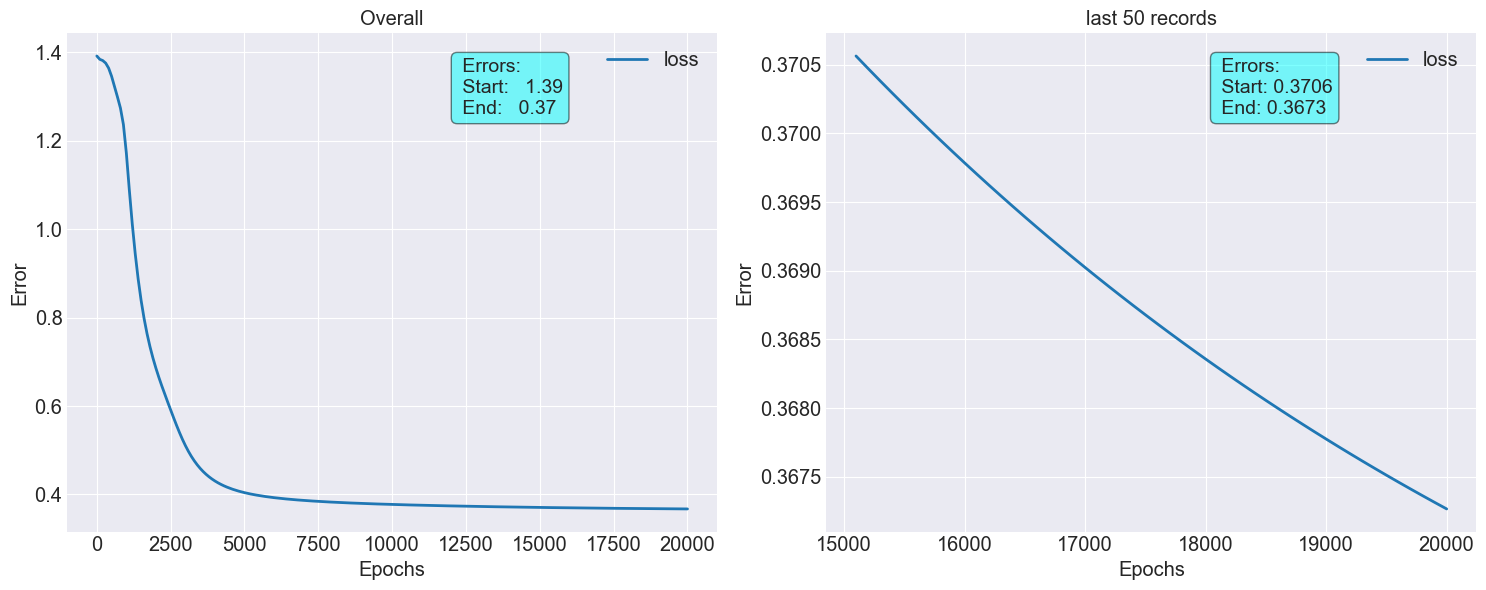

In [34]:
fig, axes = plt.subplots(1,2,figsize = (15,6))

l_range = 50

ax = axes [0]

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)

txtstr = " Errors: \n Start:{:7.2f}\n End:{:7.2f}".format(loss_df.iloc[0]['loss'], loss_df.iloc[-1]['loss'])

props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

ax.text(0.6,0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')

ax = axes [1]

loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

txtstr = " Errors: \n Start:{:7.4f}\n End:{:7.4f}".format(loss_df.iloc[-l_range]['loss'], loss_df.iloc[-1]['loss'])

ax.text(0.6,0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('last {} records'.format(l_range))
#plt.grid()
plt.tight_layout()

In [35]:
cm = confusion_matrix(np.argmax(y_test,axis = 1), y_pred)
cm

array([[247,   9],
       [ 24, 232]], dtype=int64)

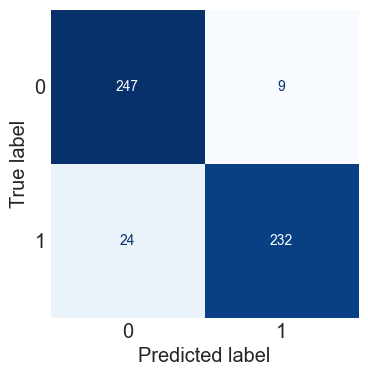

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax=ax, cmap = 'Blues', colorbar=False)
plt.grid()
plt.show();